In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

import xgboost as xgb
import keras

from ucimlrepo import fetch_ucirepo

from IPython.display import clear_output
import os
import logging
import re
import warnings

import utils

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

clear_output()

std_plot_size = (6.4, 4.8)
start_seed = 82

plots_dir = os.path.join('plots', 'part_a')
tables_dir = os.path.join('tables', 'part_a')

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)
    
sns.set_palette('hls')

minimal_run = False

rf_xgb_runs = 30 if not minimal_run else 2
reg_mlp_runs = 10 if not minimal_run else 2
dt_runs = 30 if not minimal_run else 2
mlp_runs = 30 if not minimal_run else 2

dt_depths = range(1, 21) if not minimal_run else [1, 2]
min_samples_gen = range(5, 805, 5) if not minimal_run else [790, 800]
rf_estimators = [1, 3, 5, 6, 9] + [10, 20, 40, 80, 160, 320, 640, 1280] if not minimal_run else [10, 20]
gradb_estimators = rf_estimators[:-2] if not minimal_run else [10, 20]

dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5] if not minimal_run else [0.1, 0.2]
decays = [0, 0.01, 0.001, 0.0001] if not minimal_run else [0.01, 0.001]

max_epochs = 1000 if not minimal_run else 3

logging.info('Start Execution')

INFO - 2024-11-15 01:26:52,902 - Start Execution


## Cleaning Observations

In [2]:
# Retrieve dataset
abalone_dataset = fetch_ucirepo(id=1)

# # Merge target into dataframe for easy comparisons
df = pd.concat([abalone_dataset.data.features.copy(), abalone_dataset.data.targets.copy()], axis=1)
df.to_csv('abalone.csv', index=False)

In [3]:
# Retrieve dataset
# abalone_dataset = fetch_ucirepo(id=1)

# # Merge target into dataframe for easy comparisons
# df = pd.concat([abalone_dataset.data.features.copy(), abalone_dataset.data.targets.copy()], axis=1)
df = pd.read_csv('abalone.csv')

# Filter outliers
df = df[(df.Height <= 0.5) & (df.Height > 0)].reset_index(drop=True)

# Perform Cleaning
transformed_df = df.copy()

transformed_df['is_female'] = transformed_df['Sex'].eq('F').astype(int)
transformed_df['is_infant'] = transformed_df['Sex'].eq('I').astype(int)
transformed_df = transformed_df.drop(columns='Sex')

transformed_df['age_group'] = pd.cut(transformed_df['Rings'],
                          bins=[-np.inf, 7, 10, 15, np.inf],
                          labels=[1, 2, 3, 4])

# Filter out disproportionately high weight ratios (would all be group 1)
# transformed_df = transformed_df[transformed_df.weight_ratio.lt(1)]

model_accuracy = {}

## Exploratory Visualisations

INFO - 2024-11-15 01:26:55,400 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2024-11-15 01:26:55,405 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


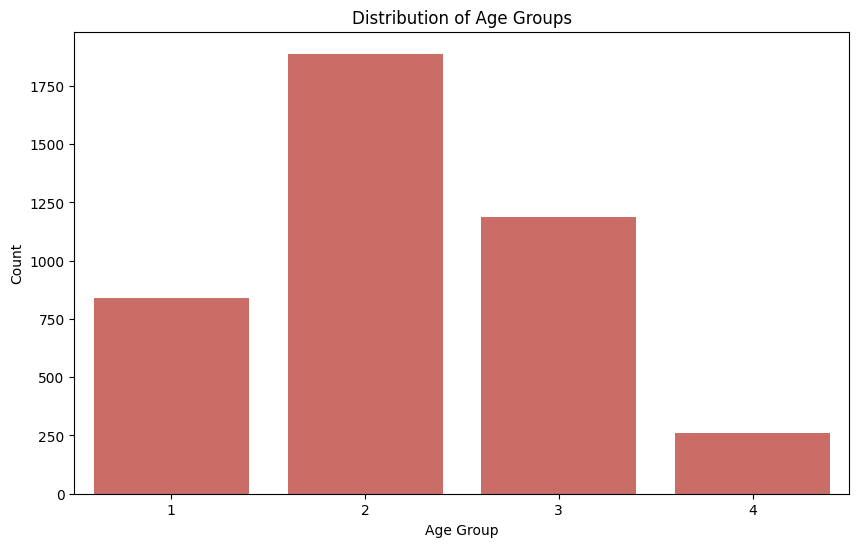

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=transformed_df)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig(os.path.join(plots_dir, 'class_distribution.png'))

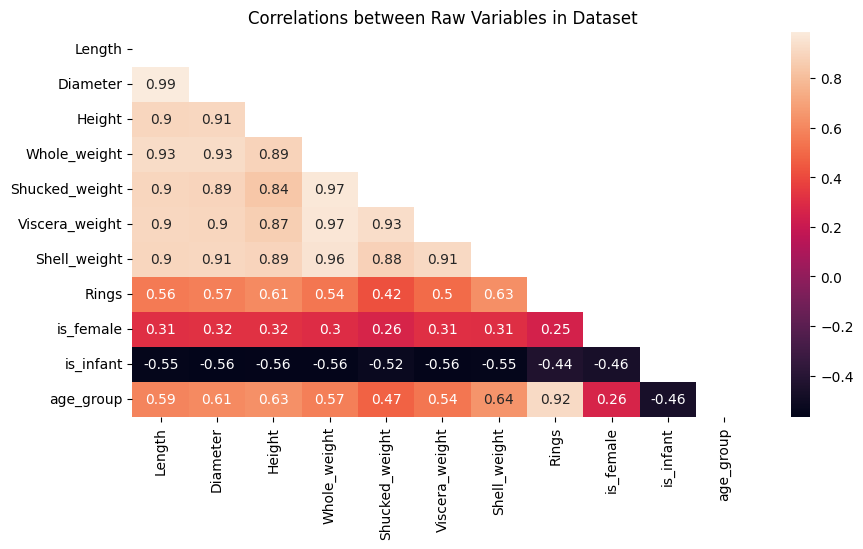

In [5]:
plt.figure(figsize=(10, 5))
plt.title('Correlations between Raw Variables in Dataset')

corr_df = transformed_df.corr()
# Create a mask of only the upper triangle, to simplify the heatmap
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.savefig(os.path.join(plots_dir, 'heat_map.png'), bbox_inches = 'tight')

In [6]:
transformed_df = transformed_df.drop(columns=['Diameter'])

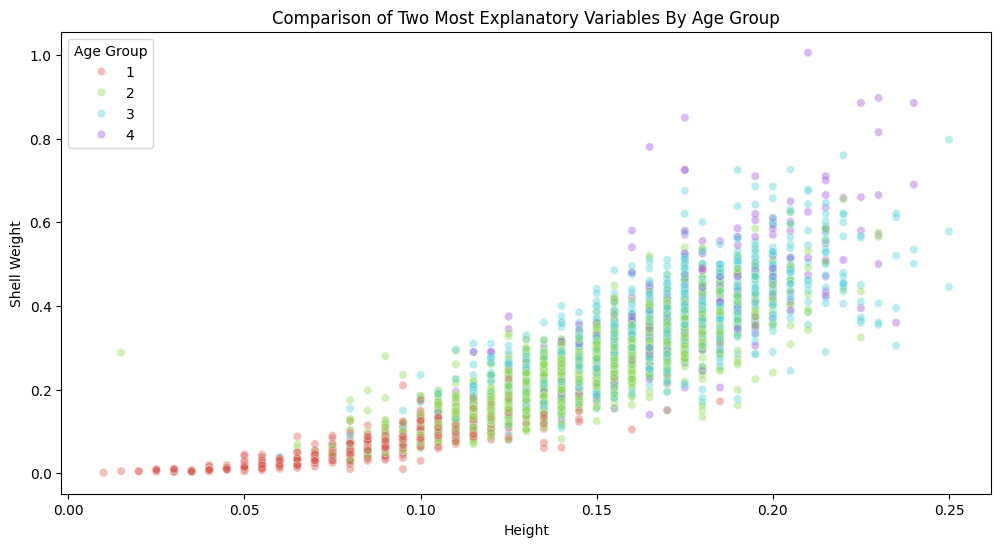

In [7]:
age_group_labels = ['1: 0-7 Rings', '2: 8-10 Rings', '3: 11-15 Rings', '4: >15 Rings']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=transformed_df, x='Height', y='Shell_weight', hue='age_group', hue_order=[1, 2, 3, 4], alpha=0.4, palette=sns.color_palette('hls', 4))
plt.legend(title='Age Group')
plt.xlabel('Height')
plt.ylabel('Shell Weight')
plt.title('Comparison of Two Most Explanatory Variables By Age Group')
plt.savefig(os.path.join(plots_dir, 'shell_weight_height_scatter.png'))

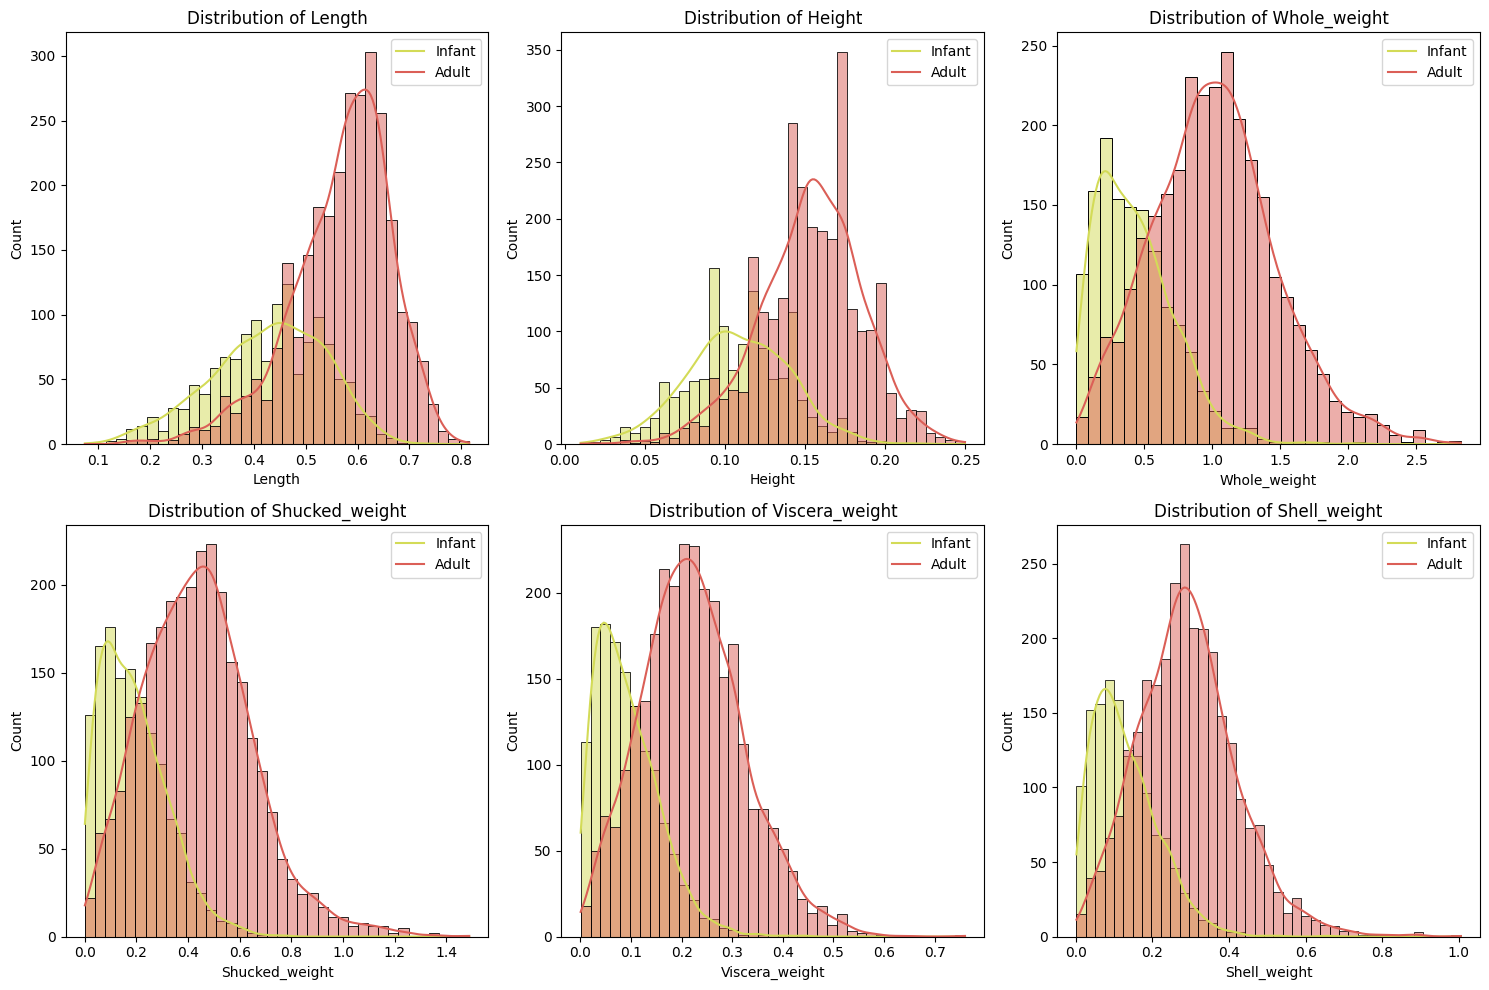

In [8]:
infant_bin_text_labels = ['Infant', 'Adult']
excluded_features = ['age_group', 'is_female', 'is_juvenile', 'is_infant', 'height_ratio', 'Rings']

features = [col for col in transformed_df.columns.tolist() if col not in excluded_features]
plt.figure(figsize=(15, 10))
for ii, feature in enumerate(features, start=1):
    plt.subplot(2, 3, ii)
    sns.histplot(data=transformed_df, x=feature, hue='is_infant', kde=True)
    plt.title(f'Distribution of {feature}')
    plt.legend(title='', loc='upper right', labels=infant_bin_text_labels)
    
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_distributions.png'))

In [9]:
feature_df = transformed_df.drop(['age_group', 'Rings'], axis=1)
target = transformed_df['age_group']

In [10]:
def decision_tree(feature_df, target, num_exp, tree_depth=1000, min_samples=2):
    
    full_results = []
    
    best_accuracy = 0
    best_model = None
    
    for ii in range(num_exp):
        X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.2, random_state=start_seed + ii, stratify=target)
        model = DecisionTreeClassifier(max_depth=tree_depth, min_samples_split=min_samples, random_state=start_seed + ii)
        model.fit(X_train, y_train)
        
        y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
        
        results = {
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Train F1': f1_score(y_train, model.predict(X_train), average='weighted'),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Test F1': f1_score(y_test, model.predict(X_test), average='weighted'),
        }
        
        if results['Test Accuracy'] > best_accuracy:
            best_accuracy = results['Test Accuracy']
            best_model = model
        
        full_results.append(results)
            
    return pd.DataFrame(full_results), best_model

In [11]:
dt_results_list = []
best_model_accuracy = 0
max_depth_best_model = None

subset_df = feature_df[['Shell_weight', 'Height', 'is_infant', 'is_female']]

for steps in dt_depths:
    curr_dt_df, new_model = decision_tree(subset_df, target, dt_runs, tree_depth=steps)
    curr_dt_df['Max Depth'] = steps
    
    if curr_dt_df['Test Accuracy'].max() > best_model_accuracy:
        best_model_accuracy = curr_dt_df['Test Accuracy'].max() 
        max_depth_best_model = new_model
    
    dt_results_list.append(curr_dt_df)
    
dt_results_df = pd.concat(dt_results_list)
model_accuracy['max_depth_dt'] = round(float(dt_results_df.groupby('Max Depth')['Test Accuracy'].mean().max()), 3)

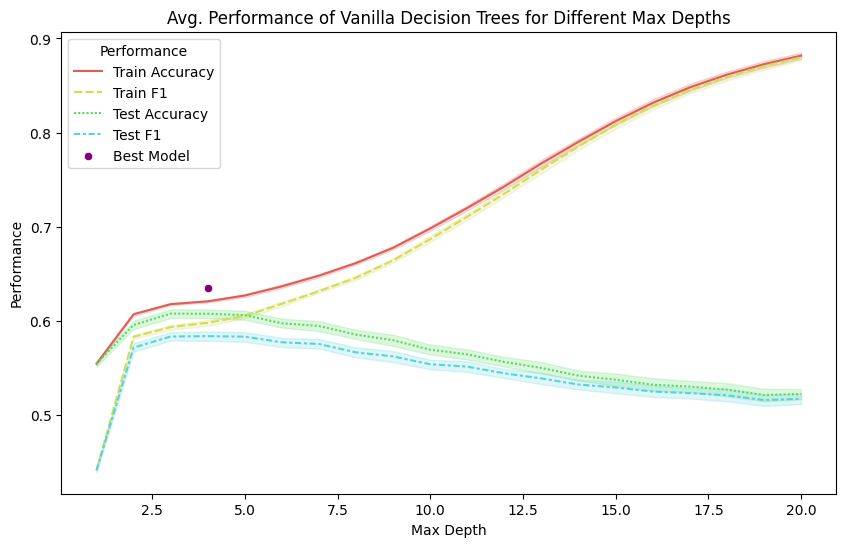

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=dt_results_df.set_index('Max Depth'))
sns.scatterplot(x=[max_depth_best_model.max_depth], y=[best_model_accuracy], color='purple', label='Best Model')
plt.legend(title='Performance')
plt.title(f'Avg. Performance of Vanilla Decision Trees for Different Max Depths')
plt.ylabel('Performance')
plt.savefig(os.path.join(plots_dir, 'max_depth_decision_tree_performance.png'))

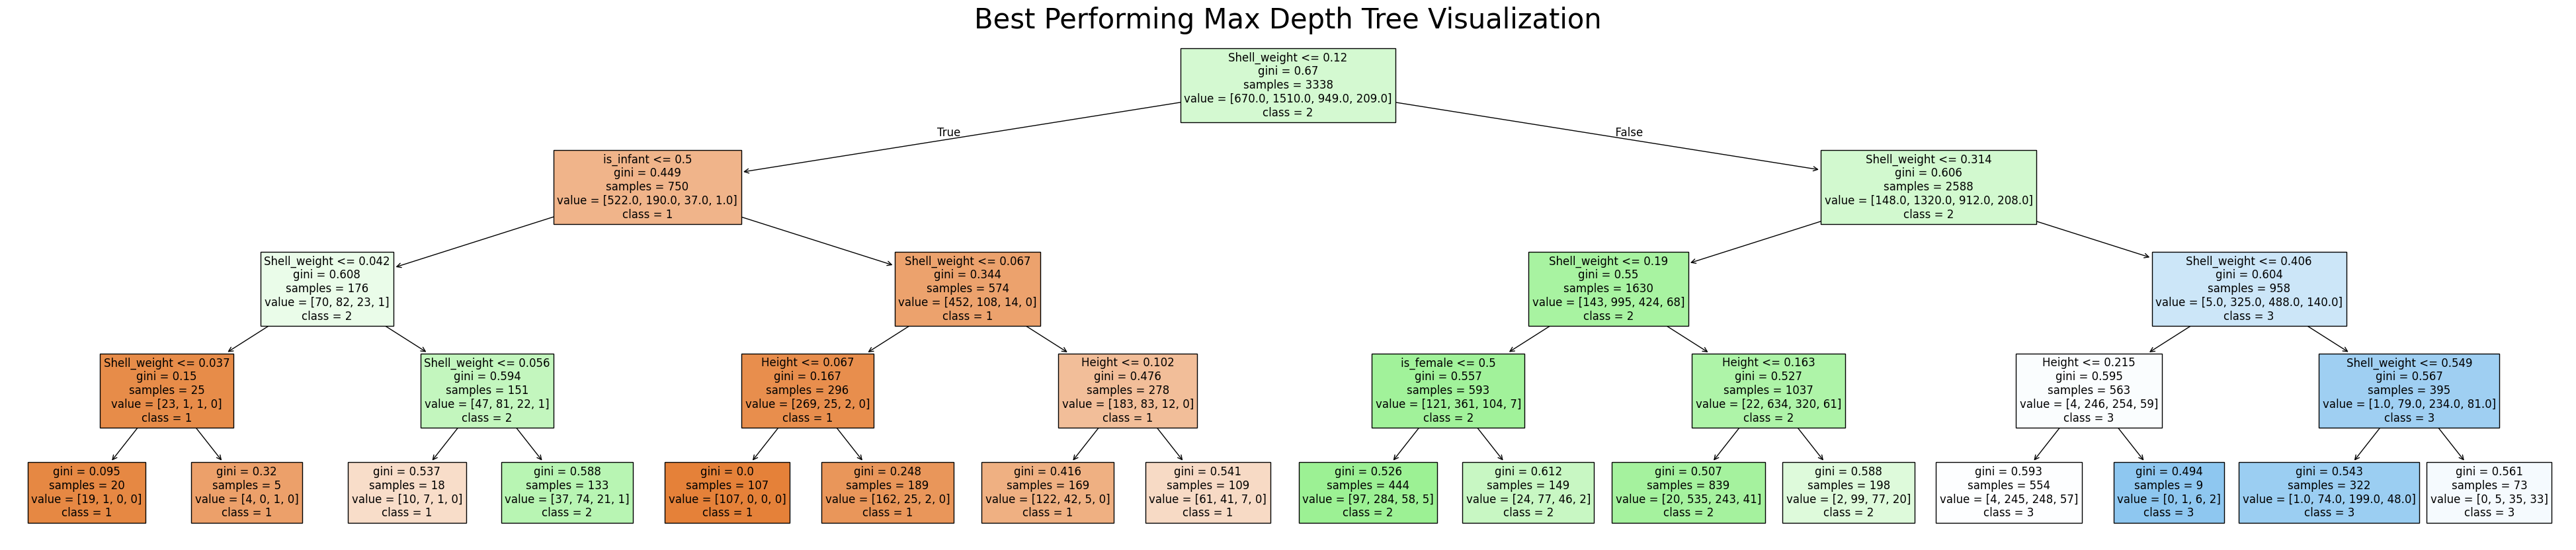

In [34]:
plt.figure(figsize=(50, 10))
plot_tree(max_depth_best_model, feature_names=subset_df.columns, class_names=['1', '2', '3', '4'], filled=True, fontsize=12)
plt.title('Best Performing Max Depth Tree Visualization', fontdict={'size': 30})
plt.savefig(os.path.join(plots_dir, 'best_max_depth_tree.png'))

In [14]:
tree_rule = export_text(max_depth_best_model, feature_names=subset_df.columns, spacing=1)
itemised_rules = tree_rule.split('\n')

rules_output = []
curr_stack = []
itemised_pointer = 0

for ii in range(2 ** max_depth_best_model.max_depth):
    curr_rule = ''
    while not curr_rule:
        if 'class' in itemised_rules[itemised_pointer]:
            class_num = re.match('.*class:\s(\d).*', itemised_rules[itemised_pointer]).group(1)
            curr_rule = f'IF ({" AND ".join(curr_stack)}) THEN AgeGroup({class_num})'
        
        else:
            if itemised_rules[itemised_pointer].count('|') <= len(curr_stack):
                curr_stack = curr_stack[:(itemised_rules[itemised_pointer].count('|') - 1)]
            curr_stack.append(itemised_rules[itemised_pointer].replace('| ', '').replace('|- ', ''))
            
        itemised_pointer += 1
    rules_output.append(curr_rule)

x = [print(x.replace('_', '\_').replace('<=', '$<=$').replace('>', '$>$') + ' \\\\') for x in rules_output]

IF (Shell\_weight $<=$ 0.12 AND is\_infant $<=$ 0.50 AND Shell\_weight $<=$ 0.04 AND Shell\_weight $<=$ 0.04) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $<=$ 0.50 AND Shell\_weight $<=$ 0.04 AND Shell\_weight $>$  0.04) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $<=$ 0.50 AND Shell\_weight $>$  0.04 AND Shell\_weight $<=$ 0.06) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $<=$ 0.50 AND Shell\_weight $>$  0.04 AND Shell\_weight $>$  0.06) THEN AgeGroup(2) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $>$  0.50 AND Shell\_weight $<=$ 0.07 AND Height $<=$ 0.07) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $>$  0.50 AND Shell\_weight $<=$ 0.07 AND Height $>$  0.07) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $>$  0.50 AND Shell\_weight $>$  0.07 AND Height $<=$ 0.10) THEN AgeGroup(1) \\
IF (Shell\_weight $<=$ 0.12 AND is\_infant $>$  0.50 AND Shell\_weight $>$  0.07 AND Height $>$  0.10) THEN Age

## Pre-Pruning

In [15]:
min_samples_list = []
best_model_accuracy = 0
min_samples_best_model = None

for size in min_samples_gen:
    curr_min_samples_df, new_model = decision_tree(feature_df, target, dt_runs, min_samples=size)
    if curr_min_samples_df['Test Accuracy'].max() > best_model_accuracy:
        min_samples_best_model = new_model
        best_model_accuracy = curr_min_samples_df['Test Accuracy'].max()
    
    curr_min_samples_df['Min Samples'] = size
    min_samples_list.append(curr_min_samples_df)
    
min_samples_df = pd.concat(min_samples_list)
model_accuracy['min_samples_dt'] = round(float(min_samples_df.groupby('Min Samples')['Test Accuracy'].mean().max()), 3)

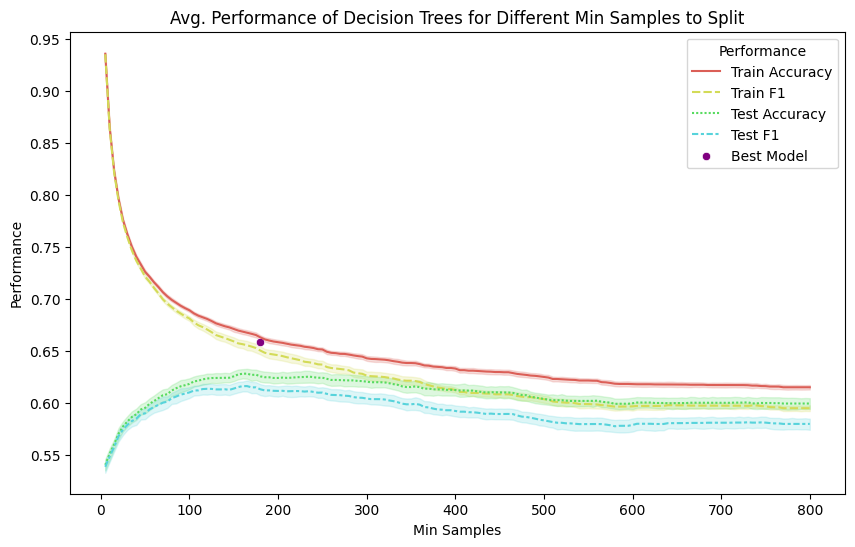

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=min_samples_df.set_index('Min Samples'))
sns.scatterplot(x=[min_samples_best_model.get_params()['min_samples_split']], y=[best_model_accuracy], color='purple', label='Best Model')
plt.legend(title='Performance')
plt.title(f'Avg. Performance of Decision Trees for Different Min Samples to Split')
plt.ylabel('Performance')
plt.savefig(os.path.join(plots_dir, 'min_samples_decision_tree_performance.png'))

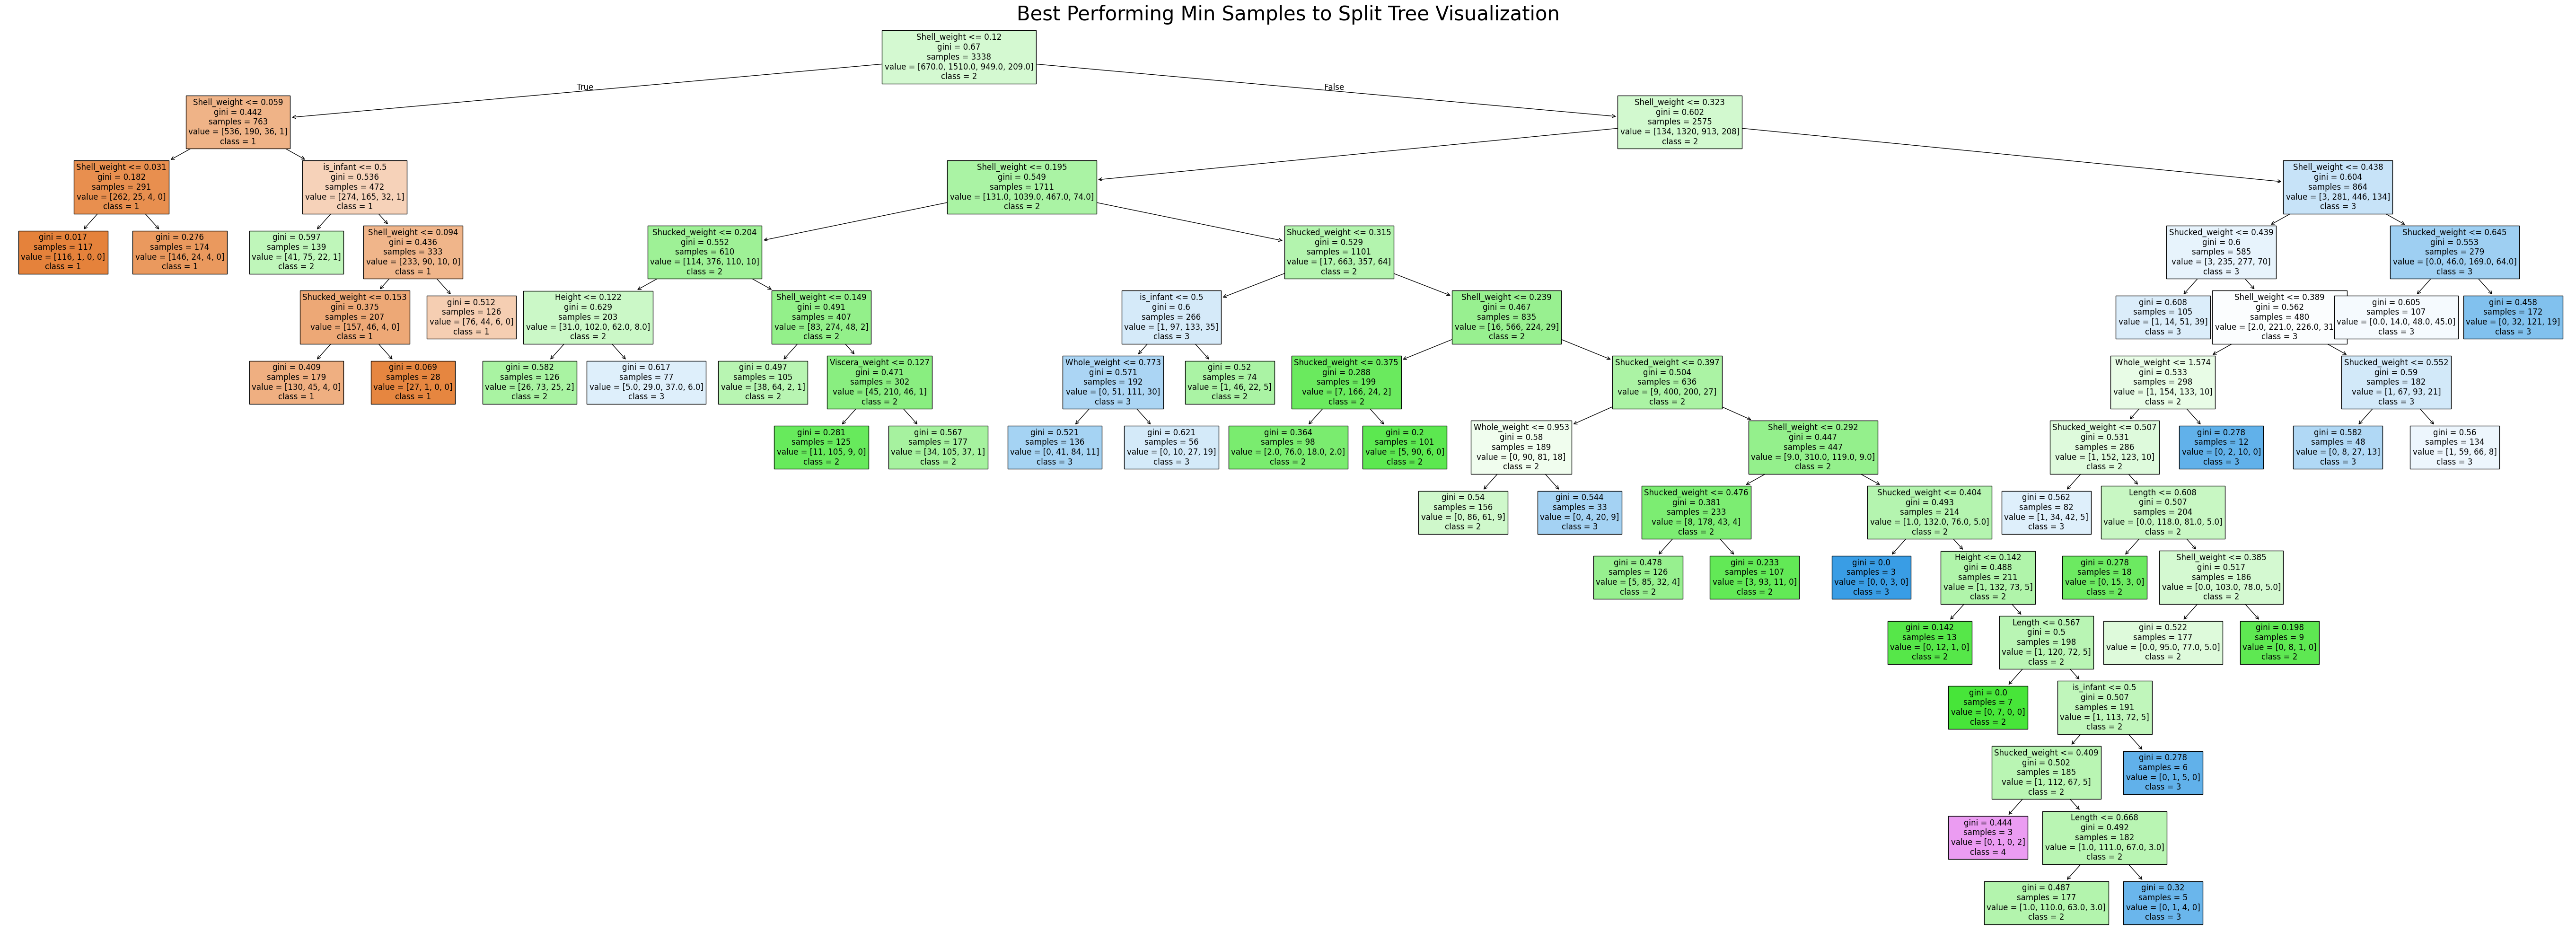

In [38]:
if not minimal_run:
    plt.figure(figsize=(70, 25))
    plot_tree(min_samples_best_model, feature_names=feature_df.columns, class_names=['1', '2', '3', '4'], filled=True, fontsize=12)
    plt.title('Best Performing Min Samples to Split Tree Visualization', fontdict={'size': 30})
    plt.savefig(os.path.join(plots_dir, 'best_min_split_tree.png'))

## Post Pruning

In [18]:
ccp_full_results = []

for ii in range(rf_xgb_runs):
    X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.2, random_state=start_seed + ii)

    model = DecisionTreeClassifier(random_state=start_seed + ii)
    model.fit(X_train, y_train)

    path = model.cost_complexity_pruning_path(X_train, y_train)

    for alpha in path.ccp_alphas[:-2]:
        pruned_model = DecisionTreeClassifier(random_state=start_seed + ii, ccp_alpha=alpha)
        pruned_model.fit(X_train, y_train)
        
        train_pred, test_pred = pruned_model.predict(X_train), pruned_model.predict(X_test)
        
        ccp_full_results.append({
            'Test Accuracy': accuracy_score(y_test, test_pred),
            'Cost-Complexity Pruning Alpha': alpha,
            'Nodes': pruned_model.tree_.node_count ,
            'Trial Num': ii
        })

In [19]:
ccp_full_results_df = pd.DataFrame(ccp_full_results)
ccp_full_results_df['alpha_bin'] = pd.qcut(ccp_full_results_df['Cost-Complexity Pruning Alpha'], 100, duplicates='drop')
ccp_full_results_df['Centre of Binned CCP Alpha'] = ccp_full_results_df['alpha_bin'].transform(lambda x: x.mid)

ccp_full_results_df['trial_max'] = ccp_full_results_df.groupby('Trial Num')['Test Accuracy'].transform('max') 
nodes_for_maxes_df = ccp_full_results_df[ccp_full_results_df['trial_max'] == ccp_full_results_df['Test Accuracy']] \
    .sort_values('Nodes') \
    .drop_duplicates('Trial Num') \
    .sort_values('Trial Num')
    
model_accuracy['ccp_dt'] = round(float(ccp_full_results_df.groupby('alpha_bin', observed=True)['Test Accuracy'].mean().max()), 3)

/home/eye4got/projects/unsw-5836-assignment-2/.venv/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


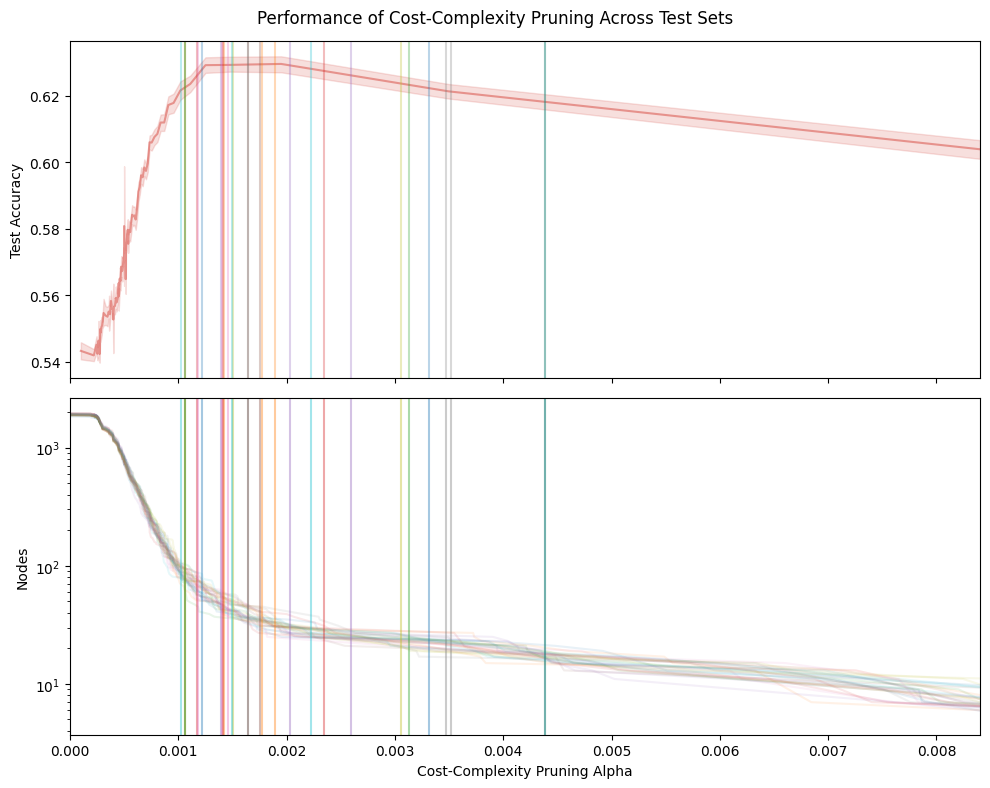

In [40]:
palette = sns.color_palette('tab10', rf_xgb_runs)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.suptitle(f'Performance of Cost-Complexity Pruning Across Test Sets')
sns.lineplot(data = ccp_full_results_df, x='Centre of Binned CCP Alpha', y='Test Accuracy', alpha=0.6, ax=ax1)

for ii, col in enumerate(palette):
    ax1.axvline(nodes_for_maxes_df['Cost-Complexity Pruning Alpha'].iloc[ii], 0, ccp_full_results_df['Nodes'].max(), color=col, alpha=0.3)

x_max = ccp_full_results_df['Centre of Binned CCP Alpha'].max()
sns.lineplot(x='Cost-Complexity Pruning Alpha', y='Nodes', hue='Trial Num', palette=palette, data=ccp_full_results_df, alpha=0.1, ax=ax2, legend=False)
ax2.set_xlim((0, x_max))
plt.yscale('log')

for ii, col in enumerate(palette):
    ax2.axvline(nodes_for_maxes_df['Cost-Complexity Pruning Alpha'].iloc[ii], 0, ccp_full_results_df['Nodes'].max(), color=col, alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'ccp_accuracy_tradeoff.png'))

## Random Forest

In [21]:
model_estimators = {}

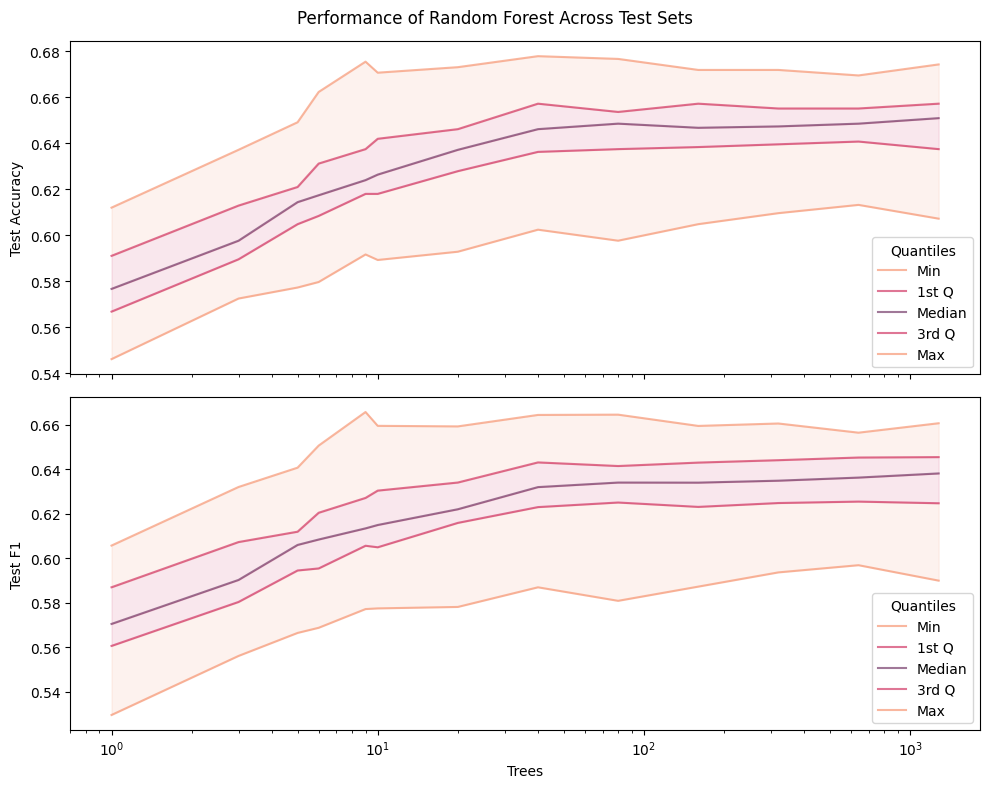

In [22]:
rf_df = utils.classifier_test(feature_df, target, RandomForestClassifier, {'max_depth': 10},
                         rf_estimators, 'n_estimators', False, 'Trees', rf_xgb_runs, True, start_seed
                         )

utils.plot_classifier_results('Random Forest', rf_df, 'Trees', True, plots_dir, True)

model_accuracy['random_forest'] = round(float(rf_df.groupby('Trees')['Test Accuracy'].mean().max()), 3)
model_estimators['random_forest'] = int(rf_df.groupby('Trees')['Test Accuracy'].mean().idxmax())

## XGBoost

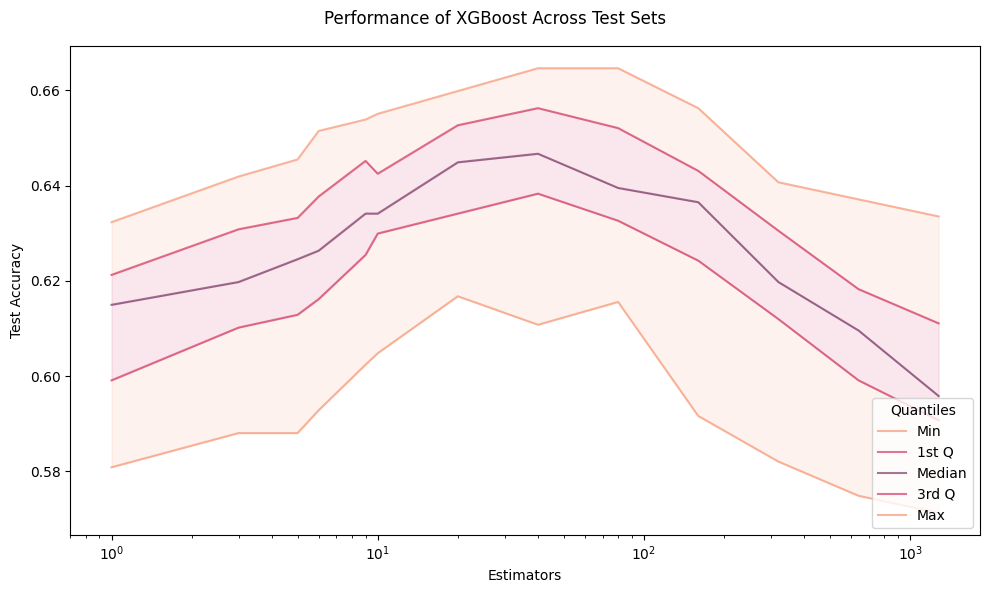

In [23]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

xgb_df = utils.classifier_test(feature_df, target_encoded, xgb.XGBClassifier, {'max_depth': 3},
                         rf_estimators, 'n_estimators', False, 'Estimators', rf_xgb_runs, True, start_seed
                         )

utils.plot_classifier_results('XGBoost', xgb_df, 'Estimators', True, plots_dir)

model_accuracy['xg_boost'] = round(float(xgb_df.groupby('Estimators')['Test Accuracy'].mean().max()), 3)
model_estimators['xg_boost'] = int(xgb_df.groupby('Estimators')['Test Accuracy'].mean().idxmax())

## Gradient Boosting

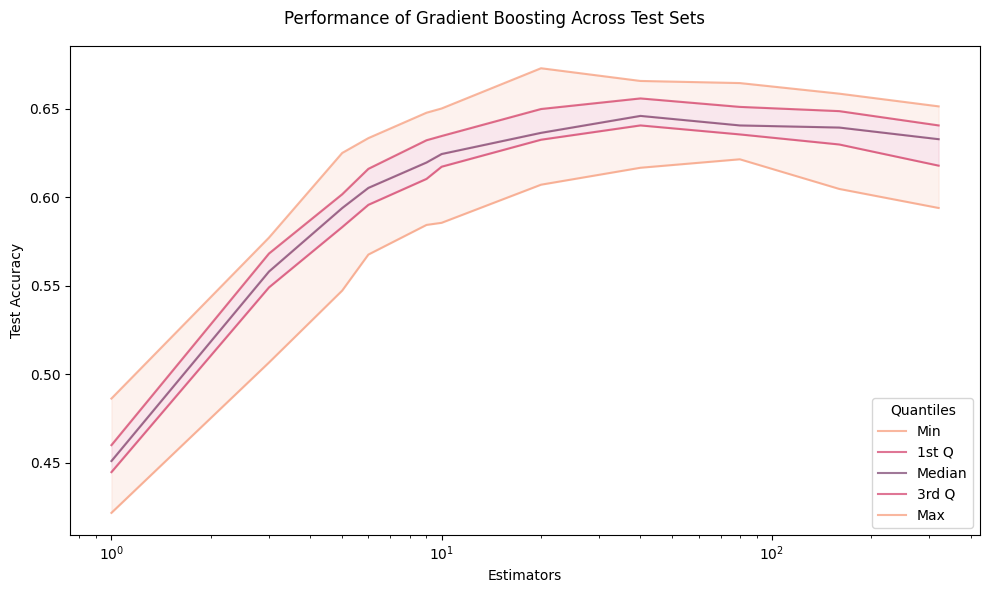

In [24]:
gradboost_df = utils.classifier_test(feature_df, target, GradientBoostingClassifier, {},
                         gradb_estimators, 'n_estimators', False, 'Estimators', rf_xgb_runs, True, start_seed
                         )

utils.plot_classifier_results('Gradient Boosting', gradboost_df, 'Estimators', True, plots_dir)

model_accuracy['grad_boost'] = round(float(gradboost_df.groupby('Estimators')['Test Accuracy'].mean().max()), 3)
model_estimators['grad_boost'] = int(gradboost_df.groupby('Estimators')['Test Accuracy'].mean().idxmax())

In [25]:
model_estimators

{'random_forest': 1280, 'xg_boost': 40, 'grad_boost': 40}

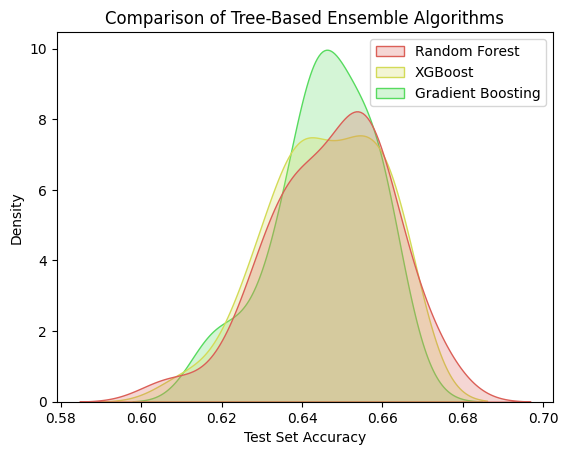

In [26]:
opt_trees_rf = rf_df.groupby('Trees')['Test Accuracy'].mean().idxmax()
trees_rf_dist = rf_df['Test Accuracy'][rf_df['Trees'].eq(opt_trees_rf)]

opt_xgb = xgb_df.groupby('Estimators')['Test Accuracy'].mean().idxmax()
xgb_dist = xgb_df['Test Accuracy'][xgb_df['Estimators'].eq(opt_xgb)]

opt_gradboost = gradboost_df.groupby('Estimators')['Test Accuracy'].mean().idxmax()
gradboost_dist = gradboost_df['Test Accuracy'][gradboost_df['Estimators'].eq(opt_gradboost)]

comparison_df = pd.concat([trees_rf_dist, xgb_dist, gradboost_dist], axis=1)
comparison_df.columns = ['Random Forest', 'XGBoost', 'Gradient Boosting']
plt.figure(figsize=(std_plot_size))
sns.kdeplot(comparison_df, fill=True)
plt.xlabel('Test Set Accuracy')
plt.title('Comparison of Tree-Based Ensemble Algorithms')
plt.savefig(os.path.join(plots_dir, 'tree_ensemble_kde.png'))

## MLP

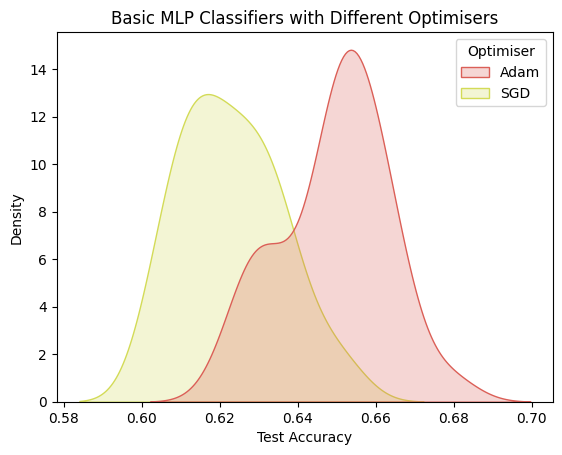

In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp_adam_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'adam'},
                            [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                            )

    mlp_adam_df['Optimiser'] = 'Adam'

    mlp_sgd_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'sgd'},
                            [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                            )
    mlp_sgd_df['Optimiser'] = 'SGD'

sns.kdeplot(data=pd.concat([mlp_adam_df, mlp_sgd_df]), x='Test Accuracy', hue='Optimiser', fill=True)
plt.title('Basic MLP Classifiers with Different Optimisers')
plt.savefig(os.path.join(plots_dir, 'optimiser_comparison.png'))

model_accuracy['mlp_adam'] = round(float(mlp_adam_df['Test Accuracy'].mean().max()), 3)
model_accuracy['mlp_sgd'] = round(float(mlp_sgd_df['Test Accuracy'].mean().max()), 3)

## Simple Neural Networks

In [28]:
def create_ssn_model(feature_df, weight_decay, dropout_rate):
    inputs = keras.Input(shape=(feature_df.shape[1],))
    x = keras.layers.Dense(32, activation='relu')(inputs)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    outputs = keras.layers.Dense(4, activation='softmax')(x)

    adam = keras.optimizers.Adam(learning_rate=0.01, weight_decay=weight_decay)

    ssn_model = keras.Model(inputs=inputs, outputs=outputs)
    ssn_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return ssn_model

I0000 00:00:1731595554.592901 1682259 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1731595556.399596 1690370 service.cc:148] XLA service 0x7f9748004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731595556.399714 1690370 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-15 01:45:56.429309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731595556.512339 1690370 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-15 01:45:57.570895: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

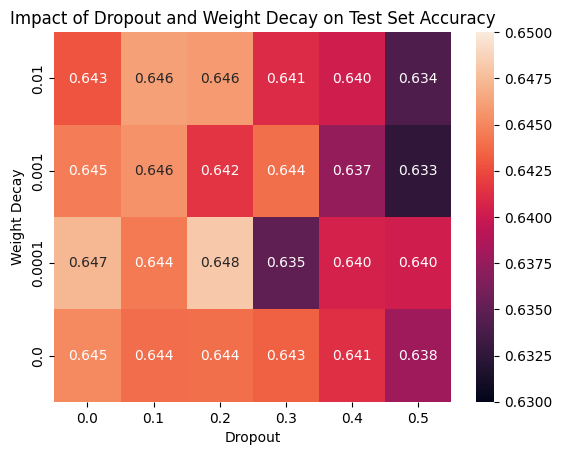

In [29]:
full_results = []

hyperparameter_combinations = [{'dropout_rate': x, 'weight_decay': y} for x in dropouts for y in decays]
combs = len(hyperparameter_combinations)

for ii in range(reg_mlp_runs):
    X_train, X_test, y_train, y_test = train_test_split(feature_df, target_encoded, test_size=0.2, random_state=start_seed + ii)

    for jj, hyper_params in enumerate(hyperparameter_combinations):
        model = create_ssn_model(feature_df, **hyper_params)
        early_stopping = keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
        )
        model.fit(X_train, y_train, epochs=max_epochs, batch_size=128, validation_split=0.1, verbose=0, callbacks=[early_stopping])
        
        test_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        
        full_results.append({
            'Test Accuracy': accuracy_score(y_test, test_pred),
            'Test F1': f1_score(y_test, test_pred, average='weighted'),
            'Dropout': hyper_params['dropout_rate'],
            'Weight Decay': hyper_params['weight_decay'],
            'Trial Num': ii
        })
        
mlp_reg_df = pd.DataFrame(full_results)

mlp_reg_matrix = mlp_reg_df.groupby(['Weight Decay', 'Dropout'])['Test Accuracy'] \
    .mean() \
    .reset_index() \
    .pivot(index='Weight Decay', columns='Dropout', values='Test Accuracy') \
    .sort_values('Weight Decay', ascending=False)
    
model_accuracy['reg_adam_mlp'] = round(float(mlp_reg_matrix.max().max()), 3)

sns.heatmap(data=mlp_reg_matrix, vmin=0.63, vmax=0.65, annot=True, fmt=".3f")
plt.title('Impact of Dropout and Weight Decay on Test Set Accuracy')
plt.savefig(os.path.join(plots_dir, 'dropout_decay_heatmap.png'))

/tmp/ipykernel_1682259/374392999.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  opt_ccp_alpha = ccp_full_results_df.groupby('Centre of Binned CCP Alpha')['Test Accuracy'].mean().idxmax()


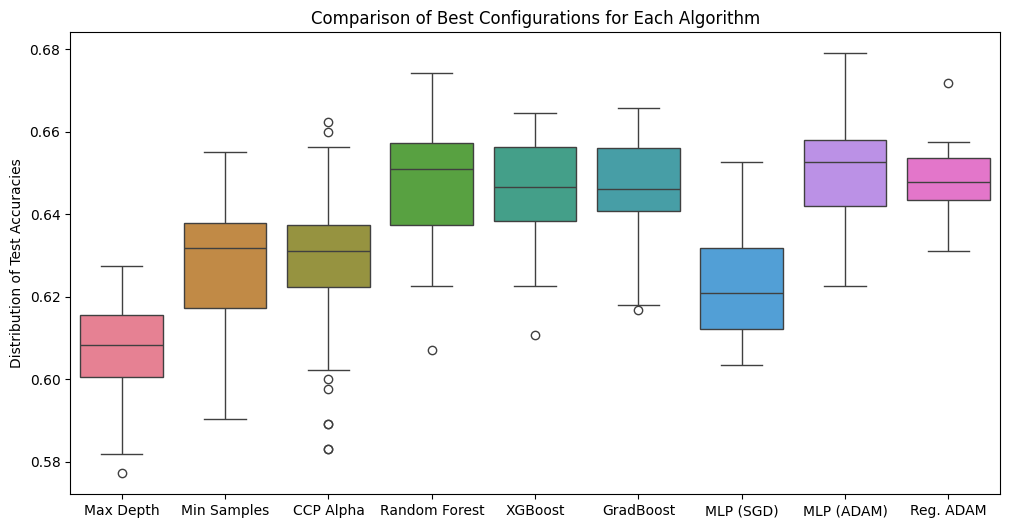

In [51]:
opt_max_depth = dt_results_df.groupby('Max Depth')['Test Accuracy'].mean().idxmax()
max_depth_dist = dt_results_df['Test Accuracy'][dt_results_df['Max Depth'].eq(opt_max_depth)]

opt_min_samples = min_samples_df.groupby('Min Samples')['Test Accuracy'].mean().idxmax()
min_samples_dist = min_samples_df['Test Accuracy'][min_samples_df['Min Samples'].eq(opt_min_samples)]

opt_ccp_alpha = ccp_full_results_df.groupby('Centre of Binned CCP Alpha')['Test Accuracy'].mean().idxmax()
ccp_alpha_dist = ccp_full_results_df['Test Accuracy'][ccp_full_results_df['Centre of Binned CCP Alpha'].eq(opt_ccp_alpha)]

opt_dropout, opt_decay = mlp_reg_df.groupby(['Dropout', 'Weight Decay'])['Test Accuracy'].mean().idxmax()
mlp_reg_dist = mlp_reg_df['Test Accuracy'][mlp_reg_df['Dropout'].eq(opt_dropout) & mlp_reg_df['Weight Decay'].eq(opt_decay)]

model_scores = [max_depth_dist, min_samples_dist, ccp_alpha_dist, trees_rf_dist, xgb_dist,
                           gradboost_dist, mlp_sgd_df['Test Accuracy'], mlp_adam_df['Test Accuracy'], mlp_reg_dist]
full_dists_df = pd.concat([x.reset_index(drop=True) for x in model_scores], axis=1, ignore_index=True)
full_dists_df.columns = ['Max Depth', 'Min Samples', 'CCP Alpha', 'Random Forest', 'XGBoost', 'GradBoost', 'MLP (SGD)', 'MLP (ADAM)', 'Reg. ADAM']

plt.figure(figsize=(12, 6))
sns.boxplot(full_dists_df)
plt.ylabel('Distribution of Test Accuracies')
plt.title('Comparison of Best Configurations for Each Algorithm')
plt.savefig(os.path.join(plots_dir, 'all_models_comparison.png'))

In [ ]:
final_results_df = full_dists_df.describe().iloc[:3].round(3)
final_results_df.iloc[0] = final_results_df.iloc[0].astype(int)
final_results_df = final_results_df.reset_index(names=['Measure'])
utils.save_table_to_tex(final_results_df, 'all_results', tables_dir)

In [70]:
final_results_df

,Measure,Max Depth,Min Samples,CCP Alpha,Random Forest,XGBoost,GradBoost,MLP (SGD),MLP (ADAM),Reg. ADAM
0,count,30.000,30.000,144.000,30.000,30.000,30.000,30.000,30.000,10.000
1,mean,0.608,0.628,0.630,0.647,0.646,0.645,0.623,0.649,0.648
2,std,0.013,0.014,0.014,0.015,0.014,0.012,0.013,0.014,0.012


In [31]:
logging.info('Finish Execution')

INFO - 2024-11-15 02:10:34,032 - Finish Execution
